# Model Training & Evaluation

**Reference:** Paper 1 — OpenFPL (Groos, 2025)

Every model run is automatically logged to `outputs/results/experiment_runs.jsonl`.
At the end, `tracker.summary()` shows the full comparison table across all runs.

## 1. Setup

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

from src.preprocessing import TIER1_FEATURES, TIER2_FEATURES
from src.evaluation import ExperimentTracker

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# One tracker for the whole notebook session
tracker = ExperimentTracker()

print('Setup complete')

Setup complete


## 2. Load Data

In [2]:
data_dir = Path('../data/processed/tier2_2020-21_to_2024_25')

X_train = pd.read_csv(data_dir / 'X_train.csv')
X_test  = pd.read_csv(data_dir / 'X_test.csv')
y_train = pd.read_csv(data_dir / 'y_train.csv')['total_points']
y_test  = pd.read_csv(data_dir / 'y_test.csv')['total_points']

# Full DataFrames for position / category grouping
train_full = pd.read_csv(data_dir / 'train_full.csv')
test_full  = pd.read_csv(data_dir / 'test_full.csv')

# Positions array — always stays aligned with X_test / y_test
test_positions = test_full['position_label'].values

# Available feature columns by tier
tier1_cols = [f for f in TIER1_FEATURES if f in X_train.columns]
tier2_cols = list(X_train.columns)   # already Tier 2

print(f'Train  : {X_train.shape[0]:,} samples')
print(f'Test   : {X_test.shape[0]:,} samples')
print(f'Tier 1 : {len(tier1_cols)} features')
print(f'Tier 2 : {len(tier2_cols)} features')

Train  : 87,940 samples
Test   : 24,020 samples
Tier 1 : 10 features
Tier 2 : 29 features


## 3. Baseline Models

### 3.1 Naive Baseline — Last 5 Average

In [3]:
naive_preds = X_test['form_last_5'].values

tracker.log(
    name='Naive: Last 5 Avg',
    y_true=y_test, y_pred=naive_preds, positions=test_positions,
    config={
        'model': 'Naive',
        'features': 'form_last_5 only',
        'n_features': 1,
        'train_seasons': '2020-21',
        'test_season': '2024-25',
    }
)

  Logged run #008 'Naive: Last 5 Avg'  RMSE=2.2113  MAE=1.1015


{'run_id': 8,
 'name': 'Naive: Last 5 Avg',
 'timestamp': '2026-02-26 21:11:09',
 'model': 'Naive',
 'features': 'form_last_5 only',
 'n_features': 1,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'overall_rmse': 2.211326779959014,
 'overall_mae': 1.1015410768803775,
 'n_test': 24020,
 'Zeros_rmse': 1.0180830627967756,
 'Zeros_mae': 0.3838989494055847,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.8861792177902044,
 'Blanks_mae': 1.3319530443756449,
 'Blanks_n': 6460,
 'Tickers_rmse': 2.086049002162335,
 'Tickers_mae': 1.5965160075329565,
 'Tickers_n': 885,
 'Haulers_rmse': 5.853802458408652,
 'Haulers_mae': 4.933136988370337,
 'Haulers_n': 2207,
 'GK_rmse': 1.7309357580144653,
 'GK_mae': 0.7606462858675248,
 'GK_n': 2486,
 'DEF_rmse': 2.0170057667687575,
 'DEF_mae': 1.0564882146439316,
 'DEF_n': 7976,
 'MID_rmse': 2.162992895886149,
 'MID_mae': 1.0718655873493976,
 'MID_n': 10624,
 'FWD_rmse': 2.421423157841541,
 'FWD_mae': 1.2302949402491736,
 'FWD_n': 2622}

### 3.2 Linear Regression

In [4]:
scaler = StandardScaler()
X_tr_t1 = scaler.fit_transform(X_train)
X_te_t1 = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_tr_t1, y_train)
lr_preds = lr.predict(X_te_t1)

tracker.log(
    name='LinearRegression Tier1',
    y_true=y_test, y_pred=lr_preds, positions=test_positions,
    config={
        'model': 'LinearRegression',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': {'fit_intercept': True, 'scaling': 'StandardScaler'}
    }
)

  Logged run #009 'LinearRegression Tier1'  RMSE=2.1177  MAE=1.1199


{'run_id': 9,
 'name': 'LinearRegression Tier1',
 'timestamp': '2026-02-26 21:11:09',
 'model': 'LinearRegression',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'fit_intercept': True, 'scaling': 'StandardScaler'},
 'overall_rmse': 2.1176775106826113,
 'overall_mae': 1.1198725380474956,
 'n_test': 24020,
 'Zeros_rmse': 0.9069328013449967,
 'Zeros_mae': 0.5263447505557716,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.3643830144453872,
 'Blanks_mae': 1.0444465170701653,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.4710502837324926,
 'Tickers_mae': 1.1427481529272212,
 'Tickers_n': 885,
 'Haulers_rmse': 6.090916558305646,
 'Haulers_mae': 5.222349749545122,
 'Haulers_n': 2207,
 'GK_rmse': 1.612018999461925,
 'GK_mae': 0.828306807340933,
 'GK_n': 2486,
 'DEF_rmse': 1.876525905376209,
 'DEF_mae': 1.083340933434576,
 'DEF_n': 7976,
 'MID_rmse': 2.018960054470234,
 'MID_mae': 1.0635683142797916,
 'MID_n': 10624,
 'FWD_rmse': 2.2676187451530576,
 'F

## 4. XGBoost — Experiment with Params

In [5]:
# --- Run 1: XGBoost default-ish ---
xgb_params = dict(n_estimators=100, max_depth=5, learning_rate=0.1,
                  subsample=1.0, colsample_bytree=1.0, random_state=42, n_jobs=-1)

xgb1 = XGBRegressor(**xgb_params)
xgb1.fit(X_train, y_train)
preds = xgb1.predict(X_test)

tracker.log(
    name='XGBoost n100 d5 lr0.1',
    y_true=y_test, y_pred=preds, positions=test_positions,
    config={
        'model': 'XGBoost',
        'features': 'Tier 2',
        'n_features': len(tier2_cols),
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': xgb_params,
    }
)

  Logged run #010 'XGBoost n100 d5 lr0.1'  RMSE=2.1097  MAE=1.0907


{'run_id': 10,
 'name': 'XGBoost n100 d5 lr0.1',
 'timestamp': '2026-02-26 21:11:10',
 'model': 'XGBoost',
 'features': 'Tier 2',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 100,
  'max_depth': 5,
  'learning_rate': 0.1,
  'subsample': 1.0,
  'colsample_bytree': 1.0,
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.1097270436923115,
 'overall_mae': 1.0906931048820665,
 'n_test': 24020,
 'Zeros_rmse': 0.948965804771849,
 'Zeros_mae': 0.47802111002907094,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.4509724992019204,
 'Blanks_mae': 1.0872570534267005,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.4761431453795655,
 'Tickers_mae': 1.154360987216571,
 'Tickers_n': 885,
 'Haulers_rmse': 5.958397941416582,
 'Haulers_mae': 5.091594436132076,
 'Haulers_n': 2207,
 'GK_rmse': 1.6591963868029236,
 'GK_mae': 0.8144717454462225,
 'GK_n': 2486,
 'DEF_rmse': 1.8778984490891029,
 'DEF_mae': 1.0579807265768089,
 'DEF_n': 7976,
 'MID_rmse': 2.024816995

In [6]:
# --- Run 2: XGBoost more trees, lower lr ---
xgb_params2 = dict(n_estimators=300, max_depth=5, learning_rate=0.05,
                   subsample=0.85, colsample_bytree=0.85, random_state=42, n_jobs=-1)

xgb2 = XGBRegressor(**xgb_params2)
xgb2.fit(X_train, y_train)
preds2 = xgb2.predict(X_test)

tracker.log(
    name='XGBoost n300 d5 lr0.05',
    y_true=y_test, y_pred=preds2, positions=test_positions,
    config={
        'model': 'XGBoost',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': xgb_params2,
    }
)

  Logged run #011 'XGBoost n300 d5 lr0.05'  RMSE=2.1151  MAE=1.0906


{'run_id': 11,
 'name': 'XGBoost n300 d5 lr0.05',
 'timestamp': '2026-02-26 21:11:10',
 'model': 'XGBoost',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 300,
  'max_depth': 5,
  'learning_rate': 0.05,
  'subsample': 0.85,
  'colsample_bytree': 0.85,
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.1151369057945306,
 'overall_mae': 1.0906023018876052,
 'n_test': 24020,
 'Zeros_rmse': 0.9393972417350914,
 'Zeros_mae': 0.47558753990725866,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.4464099582894578,
 'Blanks_mae': 1.0803669893698935,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.5117731201595557,
 'Tickers_mae': 1.1778526309540884,
 'Tickers_n': 885,
 'Haulers_rmse': 5.9887991040593755,
 'Haulers_mae': 5.117306948000988,
 'Haulers_n': 2207,
 'GK_rmse': 1.6473481028076151,
 'GK_mae': 0.8077729528003551,
 'GK_n': 2486,
 'DEF_rmse': 1.8722328526410332,
 'DEF_mae': 1.0504480140232795,
 'DEF_n': 7976,
 'MID_rmse': 2.03299

In [7]:
# --- Run 3: XGBoost deeper trees ---
xgb_params3 = dict(n_estimators=300, max_depth=7, learning_rate=0.05,
                   subsample=0.85, colsample_bytree=0.7, random_state=42, n_jobs=-1)

xgb3 = XGBRegressor(**xgb_params3)
xgb3.fit(X_train, y_train)
preds3 = xgb3.predict(X_test)

tracker.log(
    name='XGBoost n300 d7 lr0.05',
    y_true=y_test, y_pred=preds3, positions=test_positions,
    config={
        'model': 'XGBoost',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': xgb_params3,
    }
)

  Logged run #012 'XGBoost n300 d7 lr0.05'  RMSE=2.1049  MAE=1.0959


{'run_id': 12,
 'name': 'XGBoost n300 d7 lr0.05',
 'timestamp': '2026-02-26 21:11:11',
 'model': 'XGBoost',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 300,
  'max_depth': 7,
  'learning_rate': 0.05,
  'subsample': 0.85,
  'colsample_bytree': 0.7,
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.1048714207991144,
 'overall_mae': 1.095878329035457,
 'n_test': 24020,
 'Zeros_rmse': 0.9707294494009203,
 'Zeros_mae': 0.4844542054292506,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.5241328835081207,
 'Blanks_mae': 1.1191527608260528,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.5495161791454208,
 'Tickers_mae': 1.197411086523937,
 'Tickers_n': 885,
 'Haulers_rmse': 5.854892829797957,
 'Haulers_mae': 4.995232611133345,
 'Haulers_n': 2207,
 'GK_rmse': 1.6619797964052792,
 'GK_mae': 0.8112863308575142,
 'GK_n': 2486,
 'DEF_rmse': 1.884466722954426,
 'DEF_mae': 1.06067893933318,
 'DEF_n': 7976,
 'MID_rmse': 2.0512735844462

## 5. Random Forest — Experiment with Params

In [8]:
# --- Run 1: RF default ---
rf_params = dict(n_estimators=100, max_depth=None, min_samples_leaf=1,
                 max_features='sqrt', random_state=42, n_jobs=-1)

rf1 = RandomForestRegressor(**rf_params)
rf1.fit(X_train, y_train)
rf_preds1 = rf1.predict(X_test)

tracker.log(
    name='RF n100 depth=None',
    y_true=y_test, y_pred=rf_preds1, positions=test_positions,
    config={
        'model': 'RandomForest',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': rf_params,
    }
)

  Logged run #013 'RF n100 depth=None'  RMSE=2.1515  MAE=1.1766


{'run_id': 13,
 'name': 'RF n100 depth=None',
 'timestamp': '2026-02-26 21:11:12',
 'model': 'RandomForest',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 100,
  'max_depth': None,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.151545842496267,
 'overall_mae': 1.1765744480391997,
 'n_test': 24020,
 'Zeros_rmse': 1.086800729812063,
 'Zeros_mae': 0.572577256407272,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.6376861334875044,
 'Blanks_mae': 1.2597565341310963,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.4409219035754124,
 'Tickers_mae': 1.1396045197740112,
 'Tickers_n': 885,
 'Haulers_rmse': 5.827150377529953,
 'Haulers_mae': 4.907427859408376,
 'Haulers_n': 2207,
 'GK_rmse': 1.6849543921727808,
 'GK_mae': 0.8680425302327958,
 'GK_n': 2486,
 'DEF_rmse': 1.9292672742724006,
 'DEF_mae': 1.1538615627584508,
 'DEF_n': 7976,
 'MID_rmse': 2.058165678847452,
 'MID_mae': 

In [9]:
# --- Run 2: RF regularised (max_depth, min_samples_leaf) ---
rf_params2 = dict(n_estimators=300, max_depth=10, min_samples_leaf=3,
                  max_features='sqrt', random_state=42, n_jobs=-1)

rf2 = RandomForestRegressor(**rf_params2)
rf2.fit(X_train, y_train)
rf_preds2 = rf2.predict(X_test)

tracker.log(
    name='RF n300 depth=10 leaf=3',
    y_true=y_test, y_pred=rf_preds2, positions=test_positions,
    config={
        'model': 'RandomForest',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': rf_params2,
    }
)

  Logged run #014 'RF n300 depth=10 leaf=3'  RMSE=2.1261  MAE=1.0958


{'run_id': 14,
 'name': 'RF n300 depth=10 leaf=3',
 'timestamp': '2026-02-26 21:11:14',
 'model': 'RandomForest',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 300,
  'max_depth': 10,
  'min_samples_leaf': 3,
  'max_features': 'sqrt',
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.1260528971630177,
 'overall_mae': 1.095816963097191,
 'n_test': 24020,
 'Zeros_rmse': 0.9321051133774555,
 'Zeros_mae': 0.48276593976728144,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.3863361929315823,
 'Blanks_mae': 1.064273157931701,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.407220579505287,
 'Tickers_mae': 1.0958772339266265,
 'Tickers_n': 885,
 'Haulers_rmse': 6.089297114202441,
 'Haulers_mae': 5.206982276745648,
 'Haulers_n': 2207,
 'GK_rmse': 1.5998028695089792,
 'GK_mae': 0.7725750766231192,
 'GK_n': 2486,
 'DEF_rmse': 1.8823628789215094,
 'DEF_mae': 1.0811365300243325,
 'DEF_n': 7976,
 'MID_rmse': 2.0210682674704703,
 'MID_m

# 5.1 Custom Models & Feature Sets


In [10]:
import torch
from src.models import FPLNetTrainer

torch.manual_seed(42)
np.random.seed(42)

# Numpy arrays expected by PyTorch DataLoader
X_tr_np = X_train.values.astype('float32')
X_te_np = X_test.values.astype('float32')
y_tr_np = y_train.values.astype('float32')

fpl_hparams = dict(
    n_features=X_train.shape[1],
    feature_dim=8,
    hidden_dim=128,
    dropout=0.2,
)
fpl_train_cfg = dict(lr=1e-3, epochs=100, batch_size=512, patience=10)

print(f"Training FPLNet (single-task  VSN + 2×GRN)  device={torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'cpu'}")
fpl_trainer = FPLNetTrainer(**fpl_hparams, **fpl_train_cfg)
fpl_trainer.fit(X_tr_np, y_tr_np)

fpl_preds = fpl_trainer.predict(X_te_np)

tracker.log(
    name='FPLNet single-task',
    y_true=y_test.values, y_pred=fpl_preds, positions=test_positions,
    config={
        'model': 'FPLNet',
        'features': 'Tier 2',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21 to 2023-24',
        'test_season': '2024-25',
        'params': {**fpl_hparams, **fpl_train_cfg},
    }
)

Training FPLNet (single-task  VSN + 2×GRN)  device=NVIDIA GeForce RTX 4060 Laptop GPU
  Epoch  10/100  train_loss=1.0170  val_loss=1.0377
  Epoch  20/100  train_loss=1.0128  val_loss=1.0372
  Epoch  30/100  train_loss=1.0126  val_loss=1.0399
  Epoch  40/100  train_loss=1.0095  val_loss=1.0369
  Early stop at epoch 42
  Logged run #015 'FPLNet single-task'  RMSE=2.2204  MAE=0.9616


{'run_id': 15,
 'name': 'FPLNet single-task',
 'timestamp': '2026-02-26 21:15:32',
 'model': 'FPLNet',
 'features': 'Tier 2',
 'n_features': 29,
 'train_seasons': '2020-21 to 2023-24',
 'test_season': '2024-25',
 'params': {'n_features': 29,
  'feature_dim': 8,
  'hidden_dim': 128,
  'dropout': 0.2,
  'lr': 0.001,
  'epochs': 100,
  'batch_size': 512,
  'patience': 10},
 'overall_rmse': 2.2203924786272777,
 'overall_mae': 0.9616437244667151,
 'n_test': 24020,
 'Zeros_rmse': 0.5644303657800097,
 'Zeros_mae': 0.27503157143689894,
 'Zeros_n': 14468,
 'Blanks_rmse': 0.8241961919774135,
 'Blanks_mae': 0.623074907603048,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.7735046921687188,
 'Tickers_mae': 1.51901977231021,
 'Tickers_n': 885,
 'Haulers_rmse': 6.951215493980895,
 'Haulers_mae': 6.230235199153248,
 'Haulers_n': 2207,
 'GK_rmse': 1.6429426772413307,
 'GK_mae': 0.6570020067645649,
 'GK_n': 2486,
 'DEF_rmse': 1.9653767052423579,
 'DEF_mae': 0.9005514077759098,
 'DEF_n': 7976,
 'MID_rmse': 2.097

In [12]:
from src.models import FPLMultiTaskTrainer

# Auxiliary targets come from train_full — same order as X_train (both loaded from the same split)
goals_tr   = train_full['goals_scored'].values.astype('float32')
assists_tr = train_full['assists'].values.astype('float32')
cs_tr      = train_full['clean_sheets'].values.astype('float32')

torch.manual_seed(42)
np.random.seed(42)

mt_hparams = dict(
    n_features=X_train.shape[1],
    feature_dim=8,
    hidden_dim=128,
    dropout=0.2,
)
mt_train_cfg = dict(lr=1e-3, epochs=100, batch_size=512, patience=10)

print(f"Training FPLMultiTaskNet (VSN + 2×GRN + 4 heads: pts / goals / assists / CS)  device={torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'cpu'}")
mt_trainer = FPLMultiTaskTrainer(**mt_hparams, **mt_train_cfg)
mt_trainer.fit(
    X_tr_np, y_tr_np,
    goals=goals_tr, assists=assists_tr, cs=cs_tr,
)

mt_preds = mt_trainer.predict(X_te_np)

tracker.log(
    name='FPLMultiTask (pts+goals+assists+CS)',
    y_true=y_test.values, y_pred=mt_preds, positions=test_positions,
    config={
        'model': 'FPLMultiTaskNet',
        'features': 'Tier 2',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21 to 2023-24',
        'test_season': '2024-25',
        'params': {**mt_hparams, **mt_train_cfg},
    }
)

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


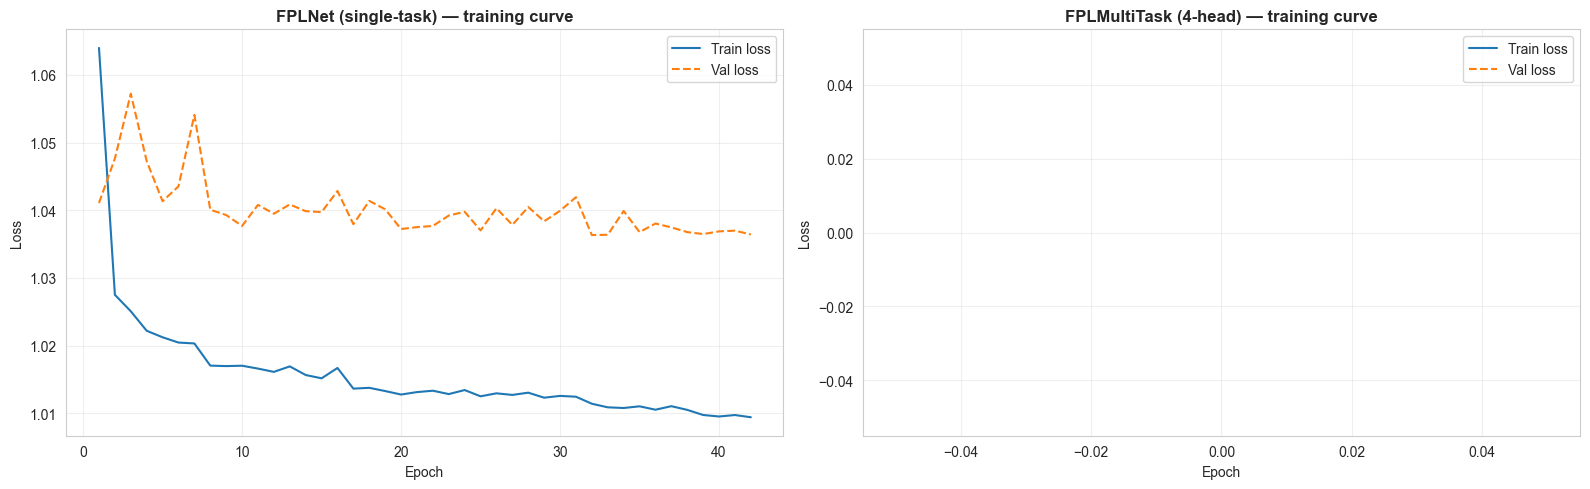

In [13]:
# Training / validation loss curves for both neural networks
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, trainer, title in zip(
    axes,
    [fpl_trainer, mt_trainer],
    ['FPLNet (single-task)', 'FPLMultiTask (4-head)'],
):
    ep = range(1, len(trainer.train_losses) + 1)
    ax.plot(ep, trainer.train_losses, lw=1.5, label='Train loss')
    ax.plot(ep, trainer.val_losses,   lw=1.5, label='Val loss',   linestyle='--')
    ax.set_title(f'{title} — training curve', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 5.3 Neural Networks — Experiment with Architectures

In [8]:
from src.models import NNTrainer, CNN, MLP
import torch
from torch.utils.data import DataLoader, TensorDataset
X_tr_np = X_train.values.astype('float32')
X_te_np = X_test.values.astype('float32')
y_tr_np = y_train.values.astype('float32')

In [ ]:




train_loader = DataLoader(TensorDataset(torch.from_numpy(X_tr_np), torch.from_numpy(y_tr_np)), batch_size=512, shuffle=True)

mlp_trainer = NNTrainer(MLP(input_size=X_train.shape[1], hidden_sizes=[32, 64, 16], output_size=1), lr=1e-3)
mlp_trainer.train(train_loader, epochs=30)


TypeError: MLP.__init__() got an unexpected keyword argument 'output_dim'

### 5.4 TabResNet — Tabular Residual Network

In [ ]:
from src.models import TabResNetTrainer

torch.manual_seed(42)
np.random.seed(42)

resnet_hparams = dict(
    n_features=X_train.shape[1],
    hidden_dim=256,
    n_blocks=4,
    dropout=0.2,
)
resnet_train_cfg = dict(lr=1e-3, epochs=100, batch_size=512, patience=10)

print(f"Training TabResNet (4 residual blocks, hidden=256)  device={torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'cpu'}")
resnet_trainer = TabResNetTrainer(**resnet_hparams, **resnet_train_cfg)
resnet_trainer.fit(X_tr_np, y_tr_np)

resnet_preds = resnet_trainer.predict(X_te_np)

tracker.log(
    name='TabResNet b4 h256',
    y_true=y_test.values, y_pred=resnet_preds, positions=test_positions,
    config={
        'model': 'TabResNet',
        'features': 'Tier 2',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21 to 2023-24',
        'test_season': '2024-25',
        'params': {**resnet_hparams, **resnet_train_cfg},
    }
)

### 5.5 FT-Transformer — Feature Tokenizer Transformer

In [ ]:
from src.models import FTTransformerTrainer

torch.manual_seed(42)
np.random.seed(42)

ftt_hparams = dict(
    n_features=X_train.shape[1],
    d_token=64,
    n_heads=8,
    n_layers=3,
    ffn_factor=4/3,
    dropout=0.1,
)
ftt_train_cfg = dict(lr=1e-3, epochs=100, batch_size=256, patience=10)

print(f"Training FT-Transformer (d=64, 8 heads, 3 layers)  device={torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'cpu'}")
ftt_trainer = FTTransformerTrainer(**ftt_hparams, **ftt_train_cfg)
ftt_trainer.fit(X_tr_np, y_tr_np)

ftt_preds = ftt_trainer.predict(X_te_np)

tracker.log(
    name='FT-Transformer d64 h8 l3',
    y_true=y_test.values, y_pred=ftt_preds, positions=test_positions,
    config={
        'model': 'FTTransformer',
        'features': 'Tier 2',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21 to 2023-24',
        'test_season': '2024-25',
        'params': {**ftt_hparams, **ftt_train_cfg},
    }
)

In [ ]:
# Training loss curves for TabResNet and FT-Transformer
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, trainer, title in zip(
    axes,
    [resnet_trainer, ftt_trainer],
    ['TabResNet', 'FT-Transformer'],
):
    ep = range(1, len(trainer.train_losses) + 1)
    ax.plot(ep, trainer.train_losses, lw=1.5, label='Train loss')
    ax.plot(ep, trainer.val_losses,   lw=1.5, label='Val loss', linestyle='--')
    ax.set_title(f'{title} — training curve', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Huber Loss')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5.6 Hauler-Weighted Training

All models trained above under-predict Haulers (5+ pts) because ~60% of rows are Zeros.
Solution: weight each training sample by `(y + 1)^power` so high-scoring rows dominate the loss.

In [3]:
def hauler_weights(y, power=1.0):
    """
    Compute per-sample weights that up-weight Hauler rows.
      weight_i = (y_i + 1)^power
    Normalised so mean weight = 1 (neutral for overall scale).

    power=0.5  moderate — square-root scaling
    power=1.0  linear  — recommended starting point
    power=2.0  strong  — aggressive focus on highest scorers
    """
    w = (np.array(y, dtype=float) + 1) ** power
    return (w / w.mean()).astype('float32')

# Distribution check: how much more weight do Haulers get vs Zeros?
for power in [0.5, 1.0, 2.0]:
    w = hauler_weights(y_train, power)
    w_zeros   = w[y_train == 0].mean()
    w_haulers = w[y_train >= 5].mean()
    print(f"power={power:.1f}  weight_zero={w_zeros:.2f}  weight_hauler={w_haulers:.2f}  "
          f"ratio={w_haulers/w_zeros:.1f}x")

power=0.5  weight_zero=nan  weight_hauler=nan  ratio=nanx
power=1.0  weight_zero=0.45  weight_hauler=3.95  ratio=8.9x
power=2.0  weight_zero=0.09  weight_hauler=7.67  ratio=87.9x


In [4]:
# XGBoost with hauler sample weights (power=1.0)
sw = hauler_weights(y_train, power=1.0)

xgb_w_params = dict(n_estimators=300, max_depth=5, learning_rate=0.05,
                    subsample=0.85, colsample_bytree=0.85, random_state=42, n_jobs=-1)

xgb_w = XGBRegressor(**xgb_w_params)
xgb_w.fit(X_train, y_train, sample_weight=sw)
xgb_w_preds = xgb_w.predict(X_test)

tracker.log(
    name='XGBoost weighted (p=1.0)',
    y_true=y_test.values, y_pred=xgb_w_preds, positions=test_positions,
    config={
        'model': 'XGBoost',
        'features': 'Tier 2',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21 to 2023-24',
        'test_season': '2024-25',
        'params': {**xgb_w_params, 'sample_weight_power': 1.0},
    }
)

XGBoostError: [22:16:42] C:\actions-runner\_work\xgboost\xgboost\src\data\data.cc:604: Check failed: valid: Weights must be positive values.

In [10]:
# Neural nets with hauler sample weights
import torch
sw = hauler_weights(y_train, power=1.0)

torch.manual_seed(42); np.random.seed(42)
from src.models import TabResNetTrainer
print("--- TabResNet weighted ---")
resnet_w = TabResNetTrainer(n_features=X_train.shape[1], hidden_dim=256,
                            n_blocks=4, dropout=0.2,
                            lr=1e-3, epochs=100, batch_size=512, patience=10)
resnet_w.fit(X_tr_np, y_tr_np, sample_weight=sw)
resnet_w_preds = resnet_w.predict(X_te_np)

tracker.log(
    name='TabResNet weighted (p=1.0)',
    y_true=y_test.values, y_pred=resnet_w_preds, positions=test_positions,
    config={
        'model': 'TabResNet',
        'features': 'Tier 2',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21 to 2023-24',
        'test_season': '2024-25',
        'params': {'hidden_dim': 256, 'n_blocks': 4, 'sample_weight_power': 1.0},
    }
)

from src.models import FTTransformerTrainer

print("--- FT-Transformer weighted ---")
ftt_w = FTTransformerTrainer(n_features=X_train.shape[1], d_token=64,
                              n_heads=8, n_layers=3, dropout=0.1,
                              lr=1e-3, epochs=100, batch_size=256, patience=10)
ftt_w.fit(X_tr_np, y_tr_np, sample_weight=sw)
ftt_w_preds = ftt_w.predict(X_te_np)

tracker.log(
    name='FTTransformer weighted (p=1.0)',
    y_true=y_test.values, y_pred=ftt_w_preds, positions=test_positions,
    config={
        'model': 'FTTransformer',
        'features': 'Tier 2',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21 to 2023-24',
        'test_season': '2024-25',
        'params': {'d_token': 64, 'n_heads': 8, 'n_layers': 3, 'sample_weight_power': 1.0},
    }
)

--- TabResNet weighted ---
  Epoch  10/100  train=3.0388  val=1.5501
  Early stop at epoch 13
  Logged run #013 'TabResNet weighted (p=1.0)'  RMSE=2.2721  MAE=1.2890
--- FT-Transformer weighted ---
  Epoch  10/100  train=3.0664  val=1.7001
  Early stop at epoch 12
  Logged run #014 'FTTransformer weighted (p=1.0)'  RMSE=2.3157  MAE=1.2814


{'run_id': 14,
 'name': 'FTTransformer weighted (p=1.0)',
 'timestamp': '2026-02-26 22:21:05',
 'model': 'FTTransformer',
 'features': 'Tier 2',
 'n_features': 29,
 'train_seasons': '2020-21 to 2023-24',
 'test_season': '2024-25',
 'params': {'d_token': 64,
  'n_heads': 8,
  'n_layers': 3,
  'sample_weight_power': 1.0},
 'overall_rmse': 2.315683124901014,
 'overall_mae': 1.2814016871368334,
 'n_test': 24020,
 'Zeros_rmse': 1.2386456214347317,
 'Zeros_mae': 0.6137195263441084,
 'Zeros_n': 14468,
 'Blanks_rmse': 2.2465759762973754,
 'Blanks_mae': 1.654192174426727,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.8853863974558362,
 'Tickers_mae': 1.5591784049898891,
 'Tickers_n': 885,
 'Haulers_rmse': 5.666176309617385,
 'Haulers_mae': 4.455831482857938,
 'Haulers_n': 2207,
 'GK_rmse': 1.7188970913771477,
 'GK_mae': 0.9316377995875893,
 'GK_n': 2486,
 'DEF_rmse': 2.2424527307266238,
 'DEF_mae': 1.4210239438332595,
 'DEF_n': 7976,
 'MID_rmse': 2.087176055741191,
 'MID_mae': 1.1015234212012377,
 'MID

In [ ]:
# Compare weighted vs unweighted on Haulers specifically
all_runs = tracker.load_runs()

hauler_mae_cols = ['name', 'Haulers_mae', 'Tickers_mae', 'Blanks_mae', 'Zeros_mae', 'overall_mae']
print("MAE by category — weighted vs unweighted runs")
print(all_runs[hauler_mae_cols].to_string(index=False, float_format=lambda x: f'{x:.4f}'))

## 6. Results — Full Run Table

In [14]:
# RMSE table
tracker.summary('rmse')


  EXPERIMENT RUNS — RMSE
 run_id                    name           timestamp  overall_rmse  Zeros_rmse  Blanks_rmse  Tickers_rmse  Haulers_rmse  GK_rmse  DEF_rmse  MID_rmse  FWD_rmse
      1       Naive: Last 5 Avg 2026-02-26 20:39:14        2.2113      1.0181       1.8862        2.0860        5.8538   1.7309    2.0170    2.1630    2.4214
      2  LinearRegression Tier1 2026-02-26 20:41:16        2.1177      0.9069       1.3644        1.4711        6.0909   1.6120    1.8765    2.0190    2.2676
      3   XGBoost n100 d5 lr0.1 2026-02-26 20:41:40        2.1097      0.9490       1.4510        1.4761        5.9584   1.6592    1.8779    2.0248    2.2533
      4  XGBoost n300 d5 lr0.05 2026-02-26 20:41:57        2.1151      0.9394       1.4464        1.5118        5.9888   1.6473    1.8722    2.0330    2.2435
      5  XGBoost n300 d7 lr0.05 2026-02-26 20:42:06        2.1049      0.9707       1.5241        1.5495        5.8549   1.6620    1.8845    2.0513    2.2716
      6      RF n100 depth

In [15]:
# MAE table
tracker.summary('mae')


  EXPERIMENT RUNS — MAE
 run_id                    name           timestamp  overall_mae  Zeros_mae  Blanks_mae  Tickers_mae  Haulers_mae  GK_mae  DEF_mae  MID_mae  FWD_mae
      1       Naive: Last 5 Avg 2026-02-26 20:39:14       1.1015     0.3839      1.3320       1.5965       4.9331  0.7606   1.0565   1.0719   1.2303
      2  LinearRegression Tier1 2026-02-26 20:41:16       1.1199     0.5263      1.0444       1.1427       5.2223  0.8283   1.0833   1.0636   1.2338
      3   XGBoost n100 d5 lr0.1 2026-02-26 20:41:40       1.0907     0.4780      1.0873       1.1544       5.0916  0.8145   1.0580   1.0324   1.2008
      4  XGBoost n300 d5 lr0.05 2026-02-26 20:41:57       1.0906     0.4756      1.0804       1.1779       5.1173  0.8078   1.0504   1.0373   1.2023
      5  XGBoost n300 d7 lr0.05 2026-02-26 20:42:06       1.0959     0.4845      1.1192       1.1974       4.9952  0.8113   1.0607   1.0470   1.2191
      6      RF n100 depth=None 2026-02-26 20:42:32       1.1766     0.5726      

In [11]:
# Best run by overall MAE
best = tracker.best_run('overall_mae')
print(f"Best run by MAE: #{int(best['run_id'])} '{best['name']}'")
print(f"  overall_rmse={best['overall_rmse']:.4f}  overall_mae={best['overall_mae']:.4f}")

Best run by MAE: #11 'FT-Transformer d64 h8 l3'
  overall_rmse=2.2254  overall_mae=0.9592


In [12]:
# Paper 1 benchmarks for reference
paper1 = {
    'run_id': '—', 'name': 'Paper1: Last5 Baseline',
    'overall_rmse': None, 'overall_mae': None,
    'Zeros_rmse': 0.791, 'Blanks_rmse': 1.400, 'Tickers_rmse': 2.136, 'Haulers_rmse': 5.613,
    'Zeros_mae':  0.270, 'Blanks_mae':  0.652, 'Tickers_mae':  1.645, 'Haulers_mae':  4.709,
}
paper2 = {
    'run_id': '—', 'name': 'Paper1: OpenFPL',
    'overall_rmse': None, 'overall_mae': None,
    'Zeros_rmse': 0.818, 'Blanks_rmse': 1.291, 'Tickers_rmse': 1.517, 'Haulers_rmse': 5.142,
    'Zeros_mae':  0.427, 'Blanks_mae':  0.749, 'Tickers_mae':  1.127, 'Haulers_mae':  4.317,
}

all_runs = tracker.load_runs()
paper_df = pd.DataFrame([paper1, paper2])

cat_rmse_cols = ['name', 'overall_rmse', 'Zeros_rmse', 'Blanks_rmse', 'Tickers_rmse', 'Haulers_rmse']
cat_mae_cols  = ['name', 'overall_mae',  'Zeros_mae',  'Blanks_mae',  'Tickers_mae',  'Haulers_mae']

combined_rmse = pd.concat([paper_df[cat_rmse_cols], all_runs[cat_rmse_cols]], ignore_index=True)
combined_mae  = pd.concat([paper_df[cat_mae_cols],  all_runs[cat_mae_cols]],  ignore_index=True)

print('RMSE BY RETURN CATEGORY (our runs + Paper 1)')
print(combined_rmse.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

print('\nMAE BY RETURN CATEGORY (our runs + Paper 1)')
print(combined_mae.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

RMSE BY RETURN CATEGORY (our runs + Paper 1)
                          name  overall_rmse  Zeros_rmse  Blanks_rmse  Tickers_rmse  Haulers_rmse
        Paper1: Last5 Baseline           NaN      0.7910       1.4000        2.1360        5.6130
               Paper1: OpenFPL           NaN      0.8180       1.2910        1.5170        5.1420
             Naive: Last 5 Avg        2.2113      1.0181       1.8862        2.0860        5.8538
        LinearRegression Tier1        2.1177      0.9069       1.3644        1.4711        6.0909
         XGBoost n100 d5 lr0.1        2.1097      0.9490       1.4510        1.4761        5.9584
        XGBoost n300 d5 lr0.05        2.1151      0.9394       1.4464        1.5118        5.9888
        XGBoost n300 d7 lr0.05        2.1049      0.9707       1.5241        1.5495        5.8549
            RF n100 depth=None        2.1515      1.0868       1.6377        1.4409        5.8272
       RF n300 depth=10 leaf=3        2.1261      0.9321       1.3863    

## 6.5 Cross-Validation (Team-Stratified, 5-Fold)

As in the OpenFPL paper: teams are ranked by average points, split into
upper/lower halves, then distributed round-robin across 5 folds.  
All gameweeks for a given team land in the **same fold** → no leakage through
shared team membership.

OOF (out-of-fold) predictions cover every training row once, giving an
unbiased in-sample estimate comparable to the paper's CV scores.

In [ ]:
from src.evaluation import TeamStratifiedKFold, cross_validate

cv = TeamStratifiedKFold(n_splits=5, random_state=42)

# Sanity-check: show fold/team assignments
team_table = cv.fold_team_table(train_full, team_col='team')
print(f"Teams per fold:")
print(team_table.groupby('fold')[['half']].value_counts().unstack(fill_value=0))
print(f"
Total unique teams: {team_table['team'].nunique()}")

In [ ]:
from xgboost import XGBRegressor

# Best XGBoost config from section 4
best_xgb_params = dict(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.85, colsample_bytree=0.85,
    random_state=42, n_jobs=-1
)

print("Cross-validating XGBoost (n=300, d=5, lr=0.05)...")
xgb_cv_model = XGBRegressor(**best_xgb_params)
xgb_cv_result = cross_validate(
    model=xgb_cv_model,
    X=X_train, y=y_train,
    full_df=train_full,
    cv=cv,
    positions_col='position_label',
    team_col='team',
)

xgb_cv_result['fold_df']

In [ ]:
# XGBoost CV with hauler sample weights
print("Cross-validating XGBoost + hauler weights (power=1.0)...")
xgb_cv_w_model = XGBRegressor(**best_xgb_params)
xgb_cv_w_result = cross_validate(
    model=xgb_cv_w_model,
    X=X_train, y=y_train,
    full_df=train_full,
    cv=cv,
    sample_weight_fn=lambda y: (y + 1).astype('float32') / (y + 1).mean(),
)

xgb_cv_w_result['fold_df']

In [ ]:
# Compare CV OOF scores vs held-out test scores
rows = [
    {'run': 'XGBoost CV (unweighted)',  **xgb_cv_result['category_mae'],  'overall_mae': xgb_cv_result['overall_mae']},
    {'run': 'XGBoost CV (weighted p=1)', **xgb_cv_w_result['category_mae'], 'overall_mae': xgb_cv_w_result['overall_mae']},
]
cv_df = pd.DataFrame(rows).set_index('run')
print("OOF CV MAE by return category")
print(cv_df[['Zeros', 'Blanks', 'Tickers', 'Haulers', 'overall_mae']].round(4).to_string())

In [ ]:
# Fold stability plot — how consistent is MAE across folds?
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, result, title in zip(
    axes,
    [xgb_cv_result, xgb_cv_w_result],
    ['XGBoost (unweighted)', 'XGBoost (weighted)'],
):
    fd = result['fold_df']
    ax.bar(fd['fold'], fd['mae'], color='steelblue', alpha=0.8, edgecolor='black')
    ax.axhline(result['overall_mae'], color='red', lw=1.5, linestyle='--',
               label=f"OOF mean={result['overall_mae']:.4f}")
    ax.set_title(f'{title} — CV fold MAE', fontweight='bold')
    ax.set_xlabel('Fold')
    ax.set_ylabel('MAE')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Visualisations

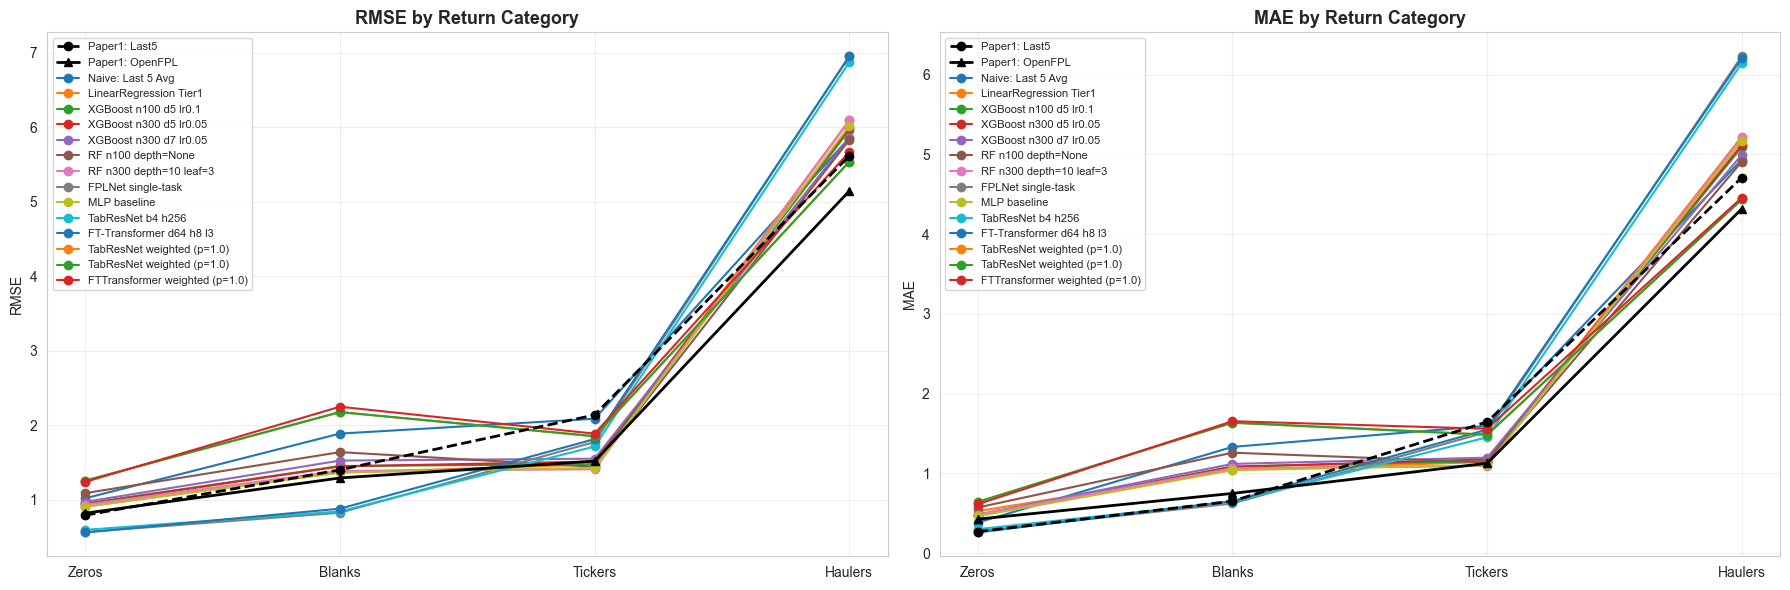

In [13]:
# RMSE by category — all runs + Paper 1
categories = ['Zeros', 'Blanks', 'Tickers', 'Haulers']
all_runs = tracker.load_runs()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for ax, metric in zip(axes, ['rmse', 'mae']):
    cols = [f'{c}_{metric}' for c in categories]

    # Paper 1 lines first
    ax.plot(categories, [paper1[c] for c in cols], 'k--o', lw=2, label='Paper1: Last5', zorder=5)
    ax.plot(categories, [paper2[c] for c in cols], 'k-^',  lw=2, label='Paper1: OpenFPL', zorder=5)

    # Our runs
    for _, row in all_runs.iterrows():
        vals = [row.get(c) for c in cols]
        ax.plot(categories, vals, '-o', lw=1.5, ms=6, label=row['name'])

    ax.set_title(f'{metric.upper()} by Return Category', fontweight='bold', fontsize=13)
    ax.set_ylabel(metric.upper())
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

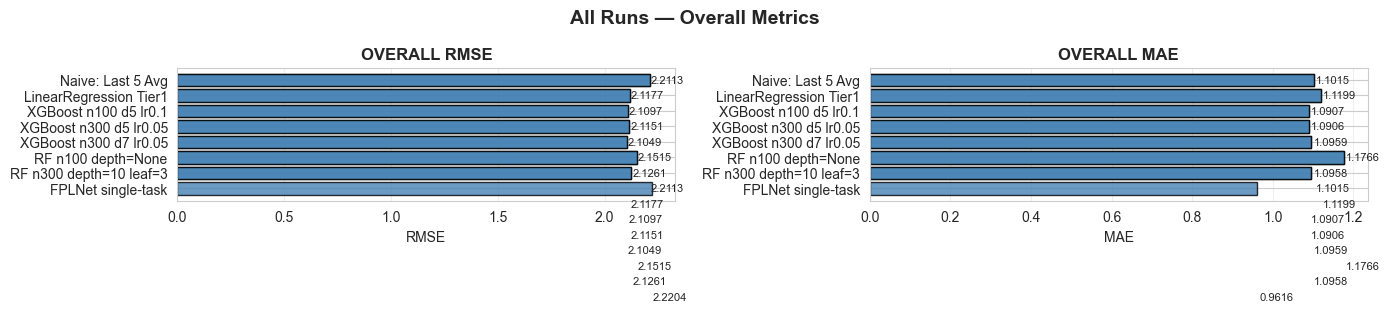

In [19]:
# Overall RMSE / MAE comparison bar chart
all_runs = tracker.load_runs()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric in zip(axes, ['overall_rmse', 'overall_mae']):
    ax.barh(all_runs['name'], all_runs[metric], color='steelblue', alpha=0.8, edgecolor='black')
    ax.set_title(metric.replace('_', ' ').upper(), fontweight='bold')
    ax.set_xlabel(metric.split('_')[1].upper())
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(all_runs[metric]):
        ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=8)

plt.suptitle('All Runs — Overall Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Best XGBoost run: #4 'XGBoost n300 d5 lr0.05'


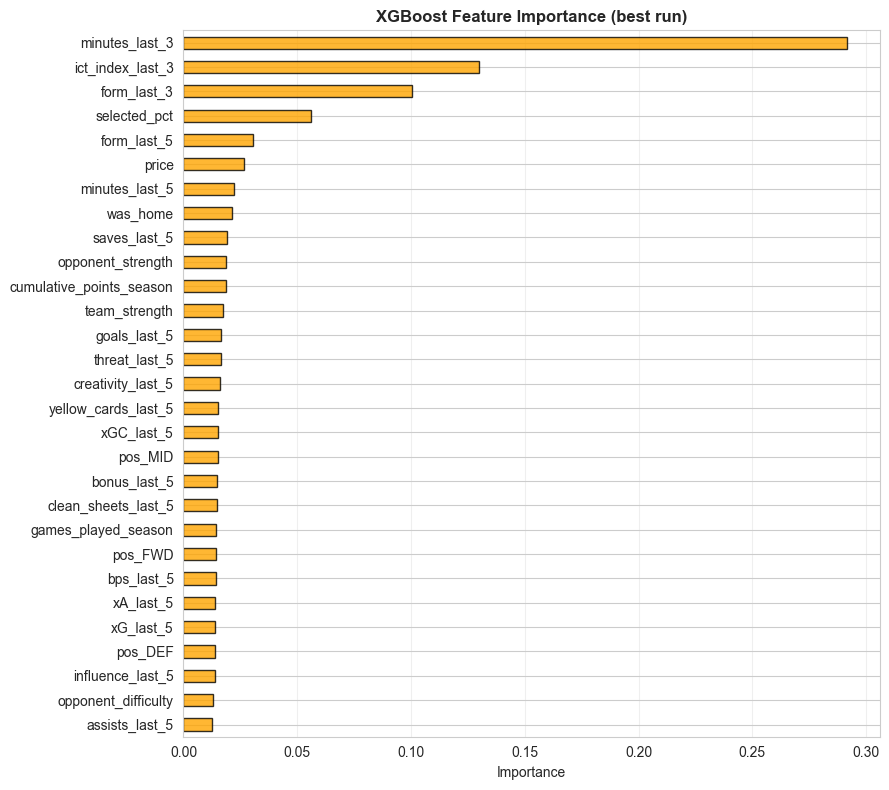

In [20]:
# Feature importance for best XGBoost run (by MAE)
xgb_runs = all_runs[all_runs['model'] == 'XGBoost']
best_xgb_idx = xgb_runs['overall_mae'].idxmin()
print(f"Best XGBoost run: #{int(all_runs.loc[best_xgb_idx, 'run_id'])} '{all_runs.loc[best_xgb_idx, 'name']}'")

# Use the last trained XGBoost (you may need to retrain if restarting the kernel)
# xgb2 = best based on the runs above — adjust if needed
best_xgb = xgb2   # change this if a different run is best

imp = pd.Series(best_xgb.feature_importances_, index=tier2_cols).sort_values()
fig, ax = plt.subplots(figsize=(9, 8))
imp.plot(kind='barh', ax=ax, color='orange', alpha=0.8, edgecolor='black')
ax.set_title('XGBoost Feature Importance (best run)', fontweight='bold')
ax.set_xlabel('Importance')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Load All Historical Runs

Runs accumulate across notebook sessions. Run this cell any time to see everything.

In [21]:
from src.evaluation import load_runs

all_runs_df = load_runs()
print(f'Total runs logged so far: {len(all_runs_df)}')
all_runs_df

Total runs logged so far: 15


,run_id,name,timestamp,model,features,n_features,train_seasons,test_season,overall_rmse,overall_mae,...,params.min_samples_leaf,params.max_features,params.n_features,params.feature_dim,params.hidden_dim,params.dropout,params.lr,params.epochs,params.batch_size,params.patience
0,1,Naive: Last 5 Avg,2026-02-26 20:39:14,Naive,form_last_5 only,1,2020-21,2024-25,2.211327,1.101541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,LinearRegression Tier1,2026-02-26 20:41:16,LinearRegression,all,29,2020-21,2024-25,2.117678,1.119873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,XGBoost n100 d5 lr0.1,2026-02-26 20:41:40,XGBoost,Tier 2,29,2020-21,2024-25,2.109727,1.090693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,XGBoost n300 d5 lr0.05,2026-02-26 20:41:57,XGBoost,all,29,2020-21,2024-25,2.115137,1.090602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,XGBoost n300 d7 lr0.05,2026-02-26 20:42:06,XGBoost,all,29,2020-21,2024-25,2.104871,1.095878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,RF n100 depth=None,2026-02-26 20:42:32,RandomForest,all,29,2020-21,2024-25,2.151546,1.176574,...,1.0,sqrt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,RF n300 depth=10 leaf=3,2026-02-26 20:42:42,RandomForest,all,29,2020-21,2024-25,2.126053,1.095817,...,3.0,sqrt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,Naive: Last 5 Avg,2026-02-26 21:11:09,Naive,form_last_5 only,1,2020-21,2024-25,2.211327,1.101541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,LinearRegression Tier1,2026-02-26 21:11:09,LinearRegression,all,29,2020-21,2024-25,2.117678,1.119873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,XGBoost n100 d5 lr0.1,2026-02-26 21:11:10,XGBoost,Tier 2,29,2020-21,2024-25,2.109727,1.090693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Clean pivot: runs × metrics (useful for sharing / exporting)
pivot = tracker.comparison_table('rmse')
pivot

,,Zeros_rmse,Blanks_rmse,Tickers_rmse,Haulers_rmse,GK_rmse,DEF_rmse,MID_rmse,FWD_rmse,overall_rmse
run_id,name,,,,,,,,,
1,Naive: Last 5 Avg,1.018083,1.886179,2.086049,5.853802,1.730936,2.017006,2.162993,2.421423,2.211327
2,LinearRegression Tier1,0.906933,1.364383,1.471050,6.090917,1.612019,1.876526,2.018960,2.267619,2.117678
3,XGBoost n100 d5 lr0.1,0.948966,1.450972,1.476143,5.958398,1.659196,1.877898,2.024817,2.253333,2.109727
4,XGBoost n300 d5 lr0.05,0.939397,1.446410,1.511773,5.988799,1.647348,1.872233,2.033000,2.243538,2.115137
5,XGBoost n300 d7 lr0.05,0.970729,1.524133,1.549516,5.854893,1.661980,1.884467,2.051274,2.271563,2.104871
6,RF n100 depth=None,1.086801,1.637686,1.440922,5.827150,1.684954,1.929267,2.058166,2.281877,2.151546
7,RF n300 depth=10 leaf=3,0.932105,1.386336,1.407221,6.089297,1.599803,1.882363,2.021068,2.246147,2.126053
8,Naive: Last 5 Avg,1.018083,1.886179,2.086049,5.853802,1.730936,2.017006,2.162993,2.421423,2.211327
9,LinearRegression Tier1,0.906933,1.364383,1.471050,6.090917,1.612019,1.876526,2.018960,2.267619,2.117678


In [ ]:
# Uncomment to reset and start fresh (deletes all logged runs!)
# tracker.clear()

NameError: name 'tracker' is not defined